### 1. Загрузка датасета и очистка данных

In [26]:
# Импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# Считываем данные, выводим размер таблицы
scores = pd.read_csv('data/raw/test_scores.csv')
scores.shape

(1984, 11)

In [28]:
# Проверяем наличие дупликатов
scores.duplicated().sum()

0

### 2. Подготовка признаков

In [29]:
# Выводим информацию о датафрейме
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   school           1984 non-null   object 
 1   school_setting   1984 non-null   object 
 2   school_type      1984 non-null   object 
 3   classroom        1984 non-null   object 
 4   teaching_method  1984 non-null   object 
 5   n_student        1984 non-null   float64
 6   student_id       1984 non-null   object 
 7   gender           1984 non-null   object 
 8   lunch            1984 non-null   object 
 9   pretest          1984 non-null   float64
 10  posttest         1984 non-null   float64
dtypes: float64(3), object(8)
memory usage: 170.6+ KB


Заметим, что в датасете для количества студентов в классе используется число с плавающей точкой, но количество людей не может быть не целым, поэтому приведем их к целому.

- Важно, при дальнейшей работе было замечено, что столбец с количеством учеников в классе может содержать неверные данные.
Необходимо произвести корректировку

In [30]:
# Исправим данные в столбце
real_n_student = scores['classroom'].value_counts()
for i in range(scores.shape[0]):
    scores.at[i, 'n_student'] = real_n_student[scores.loc[i, 'classroom']]

### 3. Анализ взаимосвязей

In [31]:
# Выводим сводные данные по числовым колонкам
scores.describe()

,n_student,pretest,posttest
count,1984.000000,1984.000000,1984.00000
mean,21.217742,54.980847,67.12500
std,4.016603,13.558027,13.93532
min,13.000000,22.000000,32.00000
25%,18.000000,44.000000,56.00000
50%,21.000000,56.000000,68.00000
75%,25.000000,65.000000,77.00000
max,29.000000,93.000000,100.00000


In [32]:
# Выводим сводные данные по нечисловым колонкам
scores.describe(include='object')

,school,school_setting,school_type,classroom,teaching_method,student_id,gender,lunch
count,1984,1984,1984,1984,1984,1984,1984,1984
unique,23,3,2,97,2,1984,2,2
top,GOOBU,Urban,Public,ZBH,Standard,2FHT3,Male,Does not qualify
freq,147,841,1463,29,1274,1,1011,1135


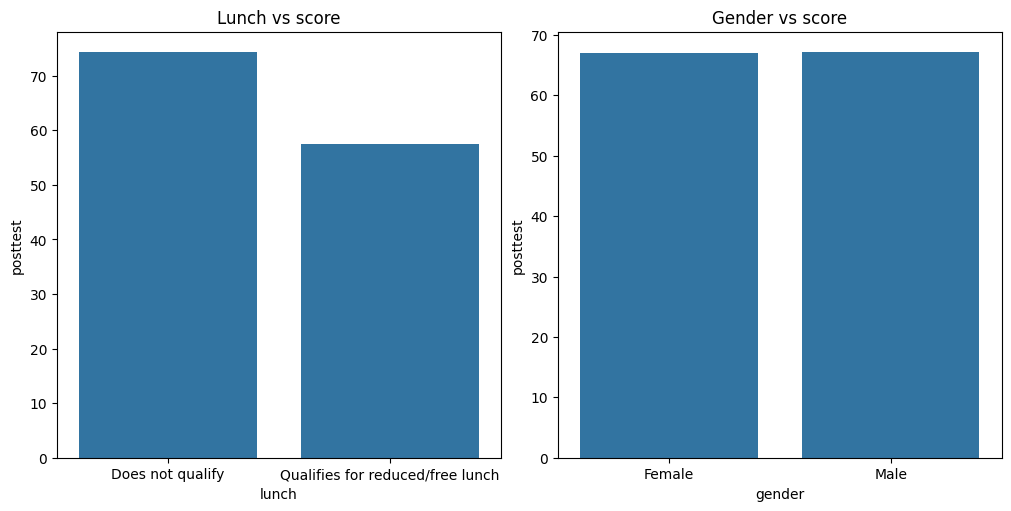

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout='constrained')

# Проверяем влияние бесплатного обеда на оценку в среднем
axs[0].set_title('Lunch vs score')
lunches = scores[['lunch', 'posttest']].groupby(['lunch']).mean()
sns.barplot(data=lunches, x='lunch', y='posttest', ax=axs[0])

# Проверяем влияние пола на оценку в среднем
axs[1].set_title('Gender vs score')
genders = scores[['gender', 'posttest']].groupby(['gender']).mean()
sns.barplot(data=genders, x='gender', y='posttest', ax=axs[1]);

Выводы:
* пол не влияет на оценку, в среднем оценки равны
* а вот факт того, является ли ученик бесплатником влияет на среднюю оценку.

---

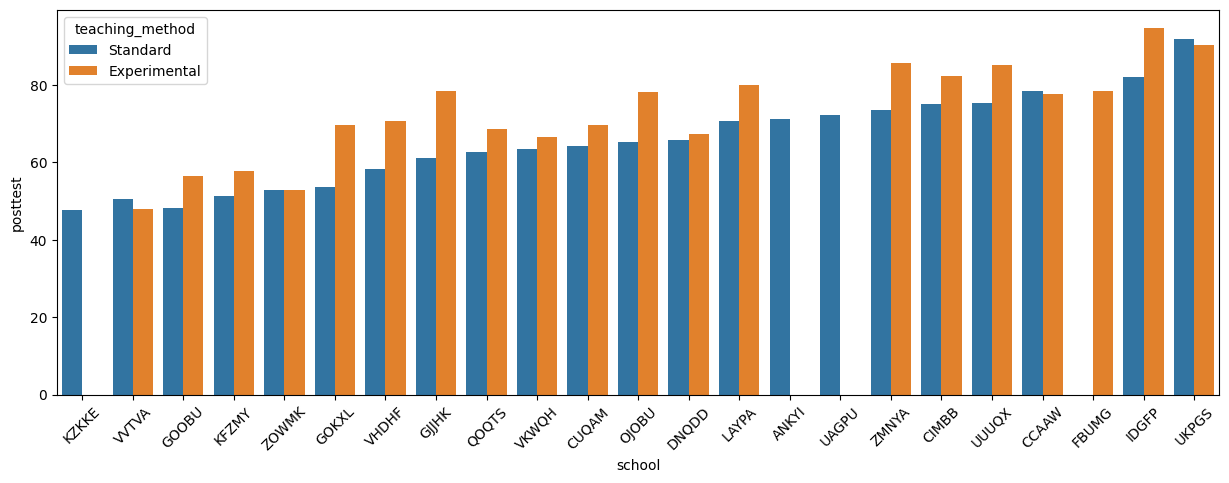

In [34]:
# Проверяем влияние школы и метода обучения на финальную оценку в среднем
schools_mean = scores[['school', 'posttest', 'teaching_method']].groupby(['school', 'teaching_method'])
schools_mean = schools_mean.mean().sort_values(by='posttest')

plt.figure(figsize=(15, 5))
ax = sns.barplot(data=schools_mean, y='posttest', x='school', hue='teaching_method')
ax.tick_params(axis='x', rotation=45)


In [35]:
max = schools_mean.posttest.max()
min = schools_mean.posttest.min()
print('Worst school mean score: ', min)
print('Best school mean score:  ', max)
print('Difference: ', max - min)

Worst school mean score:  47.73
Best school mean score:   94.65625
Difference:  46.92625


Выводы:
* школа значительно влияет на оценку в среднем. Разница средних оценок между худшей и лучшей школами составляет целых 46 баллов.
* экспериментальный способ обучения дает более высокий средний результат

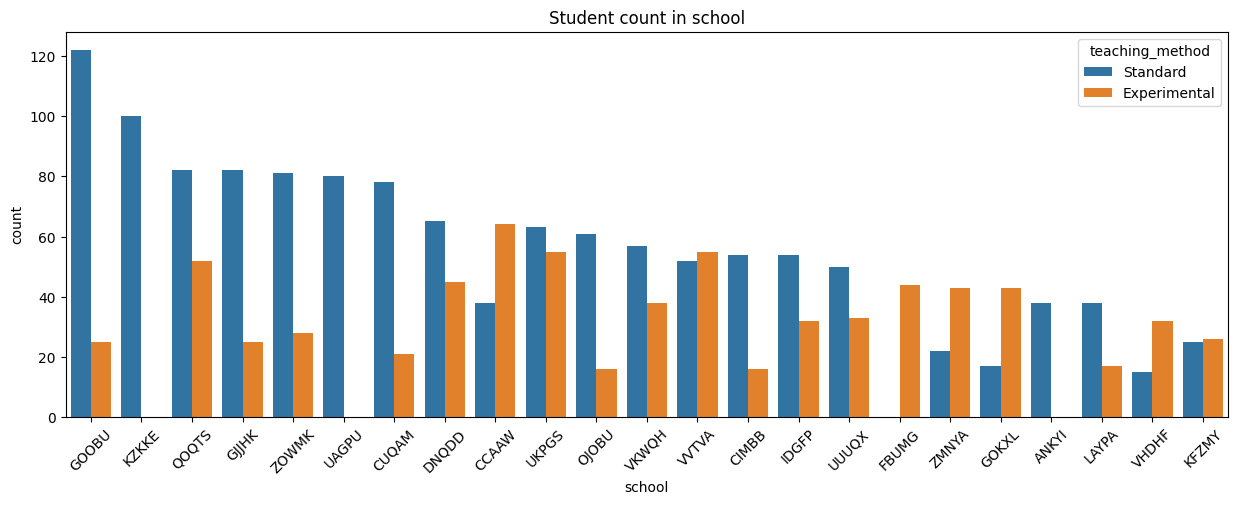

In [36]:
# Посмотрим на распределение учеников между школами
school_stud_counts = scores[['school', 'teaching_method', 'student_id']]
school_stud_counts = school_stud_counts.groupby(['school', 'teaching_method']).count()
school_stud_counts = school_stud_counts.sort_values(by='student_id', ascending=False)
school_stud_counts = school_stud_counts.rename(columns={'student_id' : 'count'})

plt.figure(figsize=(15, 5))
plt.title('Student count in school')
ax = sns.barplot(data=school_stud_counts, y='count', x='school', hue='teaching_method')
ax.tick_params(axis='x', rotation=45)

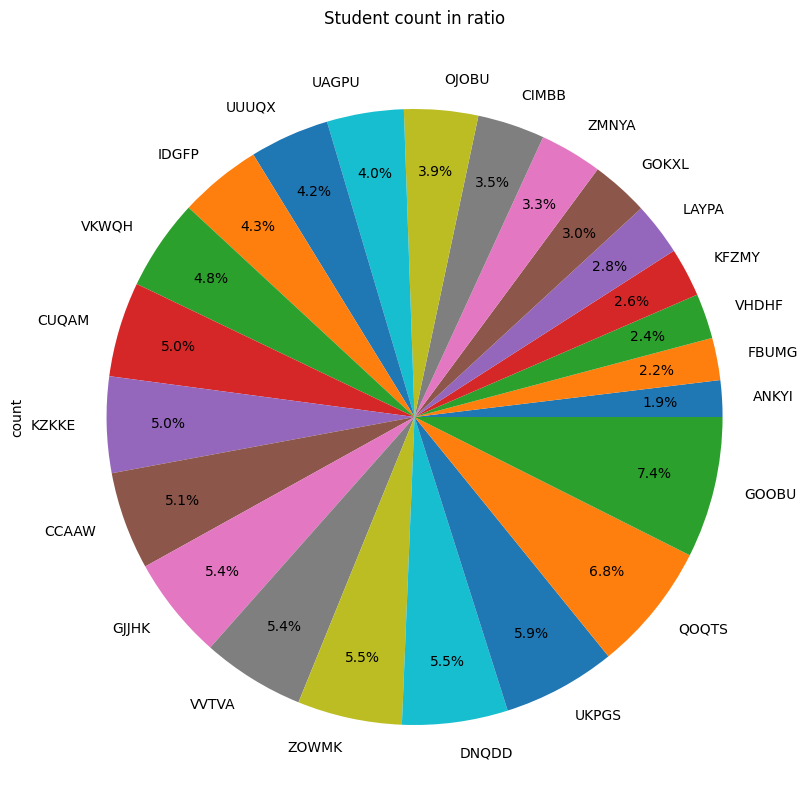

In [37]:
plt.title('Student count in ratio')
scores['school'].value_counts().sort_values().plot.pie(y='count',
                                                       autopct='%1.1f%%',
                                                       figsize=(10, 10),
                                                       pctdistance=0.8);

Как можно увидеть, ученики распределены по школам в целом равномерно

In [38]:
# Оцениваем количество учеников в школах с задаными признаками
school_diff = pd.crosstab([scores.school_type, scores.teaching_method],
                          scores.school_setting,
                          margins=True)
school_diff.style.background_gradient(cmap='summer_r')

Вывод: больше всего учеников имеют стандартный тип обучения и учатся в городских публичных школах. 

In [39]:
# Оцениваем средние оценки в школах с заданными признаками
school_diff_mean = pd.crosstab([scores.school_type, scores.teaching_method],
                          scores.school_setting,
                          margins=True,
                          values=scores.posttest,
                          aggfunc='mean')
school_diff_mean.style.background_gradient(cmap='summer_r', axis=None)

Вывод: в пригородных школах в целом средние оценки ощутимо выше.

In [40]:
# Добавим в анализ разделение по типу питания
complex_diff_mean = pd.crosstab([scores.school_type, scores.teaching_method],
                          [scores.lunch, scores.school_setting],
                          margins=True,
                          values=scores.posttest,
                          aggfunc='mean')
complex_diff_mean.style.background_gradient(cmap='summer_r', axis=None)

Вывод: анализ с дополнтельным параметром в виде наличия субсидированного питания у ученика, показаывает, что самые лучшие баллы у учеников из городских непубличных школ в классах с экспериментальным обучением без субсидированного питания

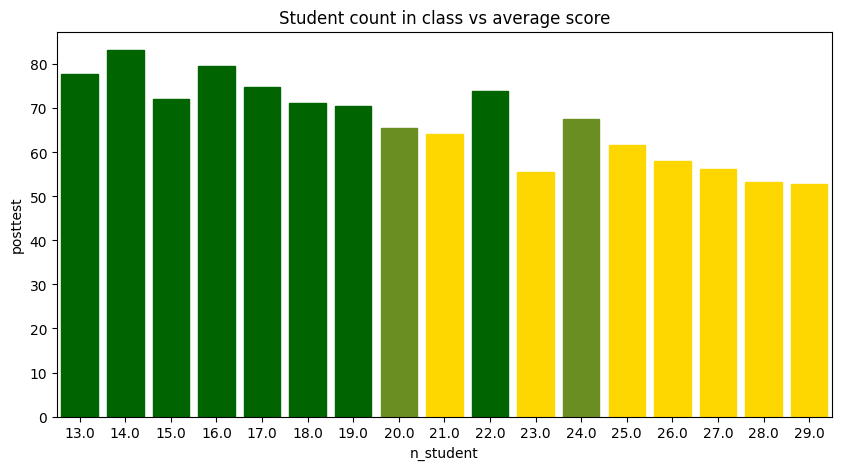

In [41]:
# Проанализируем влияние количества учников в классе на среднюю оценку за тест
class_sizes = scores[['posttest', 'n_student']].groupby('n_student')
class_sizes = class_sizes.mean().sort_values(by='n_student')

plt.figure(figsize=(10, 5))
plt.title('Student count in class vs average score')
ax = sns.barplot(data=class_sizes, y='posttest', x='n_student')
ax.tick_params(axis='x', rotation=0)

for bar in ax.patches:
    if bar.get_height() > 70:
        bar.set_color('darkgreen')
    elif bar.get_height() > 65:
        bar.set_color('olivedrab')
    else:
        bar.set_color('gold')

Вывод: как можно заметить, при росте количества учеников в классе средний балл уменьшается, но присутствуют скачки.

In [42]:
# Проанализируем топ 250 лучших учеников
top_scores = scores.sort_values(by=['posttest', 'pretest'], ascending=False)[:250]
top_diff = pd.crosstab([top_scores.school_type, top_scores.teaching_method],
                          top_scores.school_setting,
                          margins=True)
top_diff = top_diff.sort_index(axis=1)
top_diff = top_diff.sort_index(axis=0)
td = top_diff.drop('All', axis=1)
td = top_diff.drop('All', axis=0)
td.style.background_gradient(cmap='Greens', axis=None)

In [43]:
# Проанализируем топ 250 худших учеников
bottom_scores = scores.sort_values(by=['posttest', 'pretest'])[:250]
bottom_diff = pd.crosstab([bottom_scores.school_type, bottom_scores.teaching_method],
                          bottom_scores.school_setting,
                          margins=True)
bottom_diff = bottom_diff.sort_index(axis=1)
bottom_diff = bottom_diff.sort_index(axis=0)
bd = bottom_diff.drop('All', axis=1)
bd = bottom_diff.drop('All', axis=0)
bd.style.background_gradient(cmap='Oranges', axis=None)

Выводы:
* Подавляющее большинство 250 худших учеников учится в публичных школах. При этом, больше половины из них в городских
* Больше половины 250 лучших учеников учится в пригородных публичных школах, оставшаяся часть учится в частных школах

### 4. Feature engineering

In [44]:
# Новые признаки:
# 1. Фактор количества учеников в классе. Если > 23 0 иначе 1
cs = scores # completed scores
cs['f_student_count'] = (cs['n_student'] < 23).map(int)

In [45]:
# 2. Комплексный фактор школы и наличия субсидий
complex_diff_mean = complex_diff_mean.sort_index(axis=1)
complex_diff_mean = complex_diff_mean.sort_index(axis=0)
cdm = complex_diff_mean.drop('All', axis=1)
cdm = complex_diff_mean.drop('All', axis=0)
cdm.style.format(precision=2).background_gradient(cmap='summer_r', axis=None)

In [46]:
comp = complex_diff_mean.stack(level=['lunch', 'school_setting'], future_stack=True)
comp = comp.sort_values()
comp.head(comp.shape[0])

school_type  teaching_method  lunch                             school_setting
Public       Standard         Qualifies for reduced/free lunch  Rural             50.132812
                                                                Urban             50.612000
All                           Qualifies for reduced/free lunch  Urban             51.444444
Non-public   Standard         Qualifies for reduced/free lunch  Urban             51.450000
Public       Experimental     Qualifies for reduced/free lunch  Urban             52.265487
Non-public   Experimental     Qualifies for reduced/free lunch  Urban             56.681818
             Standard         Qualifies for reduced/free lunch  Rural             57.250000
All                           Qualifies for reduced/free lunch  Rural             57.867580
Public       Standard         All                                                 61.391000
Non-public   Standard         Does not qualify                  Rural             62.000000
P

In [47]:
cs['f_complex'] = 0.0
indecies = ['school_type', 'teaching_method', 'lunch', 'school_setting']
for i in range(cs.shape[0]):
    cs.at[i, 'f_complex'] = comp[tuple(cs.loc[i, indecies])]
cs.head()


,school,school_setting,school_type,classroom,teaching_method,n_student,student_id,gender,lunch,pretest,posttest,f_student_count,f_complex
0,ANKYI,Urban,Non-public,6OL,Standard,18.0,2FHT3,Female,Does not qualify,62.0,72.0,1,75.81457
1,ANKYI,Urban,Non-public,6OL,Standard,18.0,3JIVH,Female,Does not qualify,66.0,79.0,1,75.81457
2,ANKYI,Urban,Non-public,6OL,Standard,18.0,3XOWE,Male,Does not qualify,64.0,76.0,1,75.81457
3,ANKYI,Urban,Non-public,6OL,Standard,18.0,556O0,Female,Does not qualify,61.0,77.0,1,75.81457
4,ANKYI,Urban,Non-public,6OL,Standard,18.0,74LOE,Male,Does not qualify,64.0,76.0,1,75.81457


In [48]:
# 3. Средний балл класса за предварительный тест
cs['f_class_mean'] = cs[['classroom','pretest']].groupby(['classroom']).transform('mean')

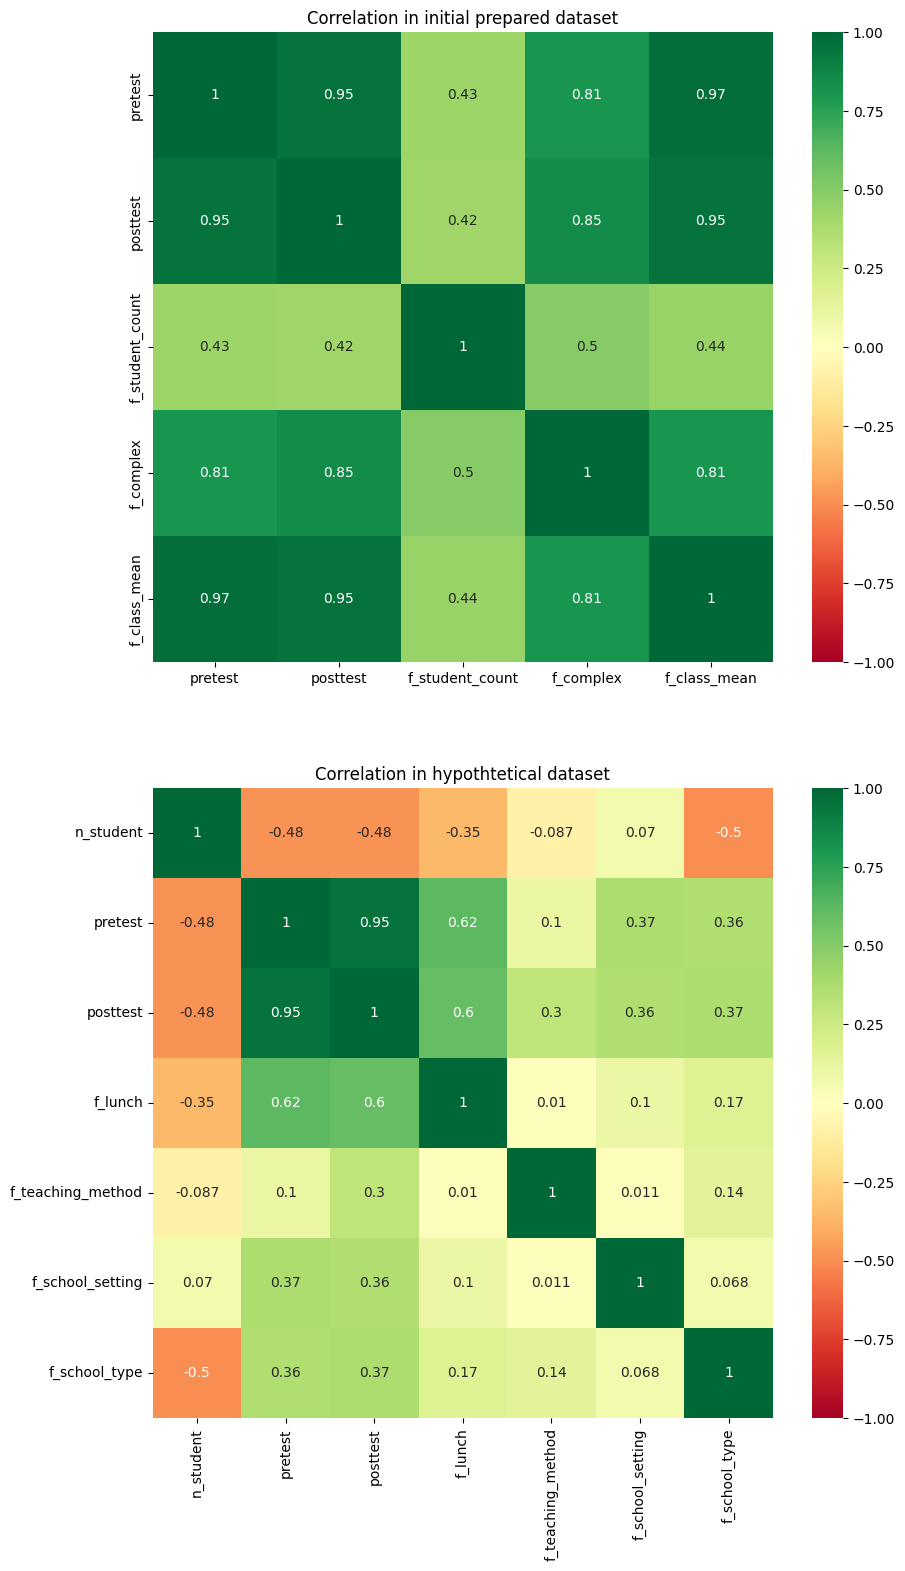

In [49]:
#  Изначальный вариант с удалением ненужных по моему мнению признаков
df_initial = cs.select_dtypes(include=['number'])
df_initial = df_initial.drop(columns='n_student')

# Тестовый вариант с оцифрованными категориальными признаками.
# Чем больше корреляция с результатом за тест, тем больше численное значение
pd.set_option('future.no_silent_downcasting', True)
df_hypothetic = cs.select_dtypes(include=['number'])
df_hypothetic = df_hypothetic.drop(columns=['f_student_count', 'f_complex', 'f_class_mean'])
df_hypothetic['f_lunch'] = cs['lunch'].replace(['Qualifies for reduced/free lunch', 'Does not qualify'], [0, 1])
df_hypothetic['f_teaching_method'] = cs['teaching_method'].replace(['Standard', 'Experimental'], [0, 1])
df_hypothetic['f_school_setting'] = cs['school_setting'].replace(['Rural', 'Urban', 'Suburban'], [0, 1, 2])
df_hypothetic['f_school_type'] = cs['school_type'].replace(['Public', 'Non-public'], [0, 1])

corr_initial = df_initial.corr()
corr_hypothetic = df_hypothetic.corr()

fix, axs = plt.subplots(2, 1, figsize=(10, 18))
sns.heatmap(corr_initial, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, ax=axs[0])
sns.heatmap(corr_hypothetic, annot=True, cmap='RdYlGn', vmin=-1, vmax=1, ax=axs[1])
axs[0].set_title('Correlation in initial prepared dataset')
axs[1].set_title('Correlation in hypothtetical dataset');

### 5. Выводы

Можно сделать вывод, что на итоговый балл влияют все признаки перечисленные в карте кореляций.
- наиболее ярко коррелируют с результатом оценка за предварительный тест и средняя оценка за предварительный тест среди класса
- также довольно сильно коррелирует с результатом наш новый комплексный признак, учитывающий тип школы, её расположение и субсидии на питание
- относительно мало коррелирует с результатом признак, учитывающий количество учеников в классе.
- сырой признак количества студентов не коррелирует с результатом, поэтому было решено убрать его из карты корреляций

In [ ]:
# Экспортируем данные для обучения модели линейной регрессии
df_initial.to_csv('data/prepared/prepared_data.csv', index=False)
df_hypothetic.to_csv('data/prepared/hypothetic_data.csv', index=False)

# MSE (initial dataset):      12.08961162157574
# MSE (hypotetical dataset):  6.474383813362675
# R2: (initial dataset):      0.9399173431220955
# R2: (hypotetical dataset):  0.9678237652845768

# NO COMPLEX FEATURE, NO COUNT CATEGORIES
# MSE (hypotetical dataset):  6.427588097816429
# R2: (hypotetical dataset):  0.9680563294899897

# также помимо того что убрали те признаки сверху, убрали средний балл по классу
# MSE (hypotetical dataset):  8.584514712154022
# R2: (hypotetical dataset):  0.957336888226154
